In [1]:
import numpy as np
import random
from skimage import io
from skimage.transform import resize
import torch
from torch.utils.data import Dataset


import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import init



import torch
import torch.nn as nn
from copy import deepcopy
from utils.utils import scores_to_permutations, permutations_to_polygons


import json
import time
import numpy as np
from tqdm import tqdm

import torch
from torch.utils.data import DataLoader

from models.matching import OptimalMatching
from models.backbone import R2U_Net, NonMaxSuppression, DetectionBranch

from utils.dataloader_crowdai import CrowdAI
from pycocotools.coco import COCO


import matplotlib.pyplot as plt


import pandas as pd



import geopandas as gpd
from shapely.geometry import Polygon
from rasterio import features

# Data

In [2]:
with open('data/val/annotation.json') as f:
    annotations = json.load(f)

images = pd.DataFrame(annotations['images'])
labels = pd.DataFrame(annotations['annotations'])

In [3]:
class CrowdAI(Dataset):
    """CrowdAI dataset"""

    def __init__(self, images_directory, annotations_path):

        self.IMAGES_DIRECTORY = images_directory
        self.ANNOTATIONS_PATH = annotations_path
        self.window_size = 320

        # load annotation json
        with open(self.ANNOTATIONS_PATH) as f:
            self.annotations = json.load(f)
        
        self.images = pd.DataFrame(self.annotations['images'])
        self.labels = pd.DataFrame(self.annotations['annotations'])
        


    def _create_segmentation_mask(self, polygons, image_shape=(320, 320)):
        # Convert the polygon coordinates to Shapely Polygon objects
        shapely_polygons = [Polygon(np.array(poly).reshape(-1, 2)) for poly in polygons]
        
        # Create a GeoDataFrame
        gdf = gpd.GeoDataFrame(geometry=shapely_polygons)
        
        # Dissolve all polygons into a single multipolygon
        merged_polygon = gdf.union_all()
        
        # Create an empty mask
        mask = np.zeros(image_shape, dtype=np.uint8)
        
        # Rasterize the merged polygon onto the mask
        shapes = [(merged_polygon, 1)]
        rasterized = features.rasterize(shapes, out_shape=image_shape)
        mask[rasterized > 0] = 255
        
        return mask


    def __len__(self):
        return len(self.images)


    def __getitem__(self, idx):

        image = io.imread(self.IMAGES_DIRECTORY + self.images['file_name'][idx])
        image = resize(image, (self.window_size, self.window_size), anti_aliasing=True)

        width, height = self.images['width'][idx], self.images['height'][idx]
        ratio = self.window_size / max(width, height)

        # Get the image ID
        image_id = self.images['id'][idx]
        
        # Get all annotations for this image
        image_annotations = self.labels[self.labels['image_id'] == image_id]
        # get all polygons
        polygons = image_annotations['segmentation'].values
        # apply ratio to coordinates
        for poly in polygons:
            poly[0] = [x * ratio for x in poly[0]]

        # create segmentation mask
        mask = self._create_segmentation_mask(polygons, image_shape=(self.window_size, self.window_size))
        # mask = resize(mask, (self.window_size, self.window_size), anti_aliasing=True)

        return image, mask

In [21]:
# Initiate the dataloader
batch_size = 4
dataset = CrowdAI(images_directory='data/val/images/', annotations_path='data/val/annotation.json')
dataloader = DataLoader(dataset, batch_size=4, collate_fn=custom_collate)

In [5]:
image, mask = next(iter(dataloader))

In [6]:
i = 0

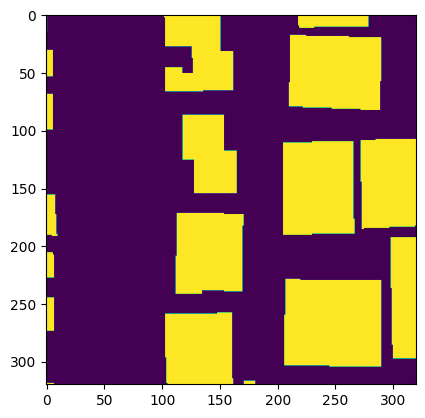

In [7]:
plt.imshow(mask[i])

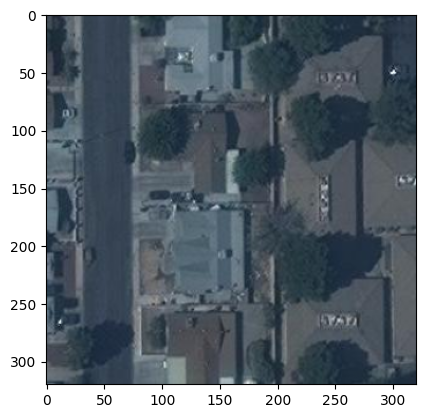

In [8]:
plt.imshow(image[i])

In [9]:
mask.shape, image.shape

(torch.Size([4, 320, 320]), torch.Size([4, 320, 320, 3]))

In [11]:
import numpy as np
from scipy.ndimage import label, find_objects

def segmentation_to_adjacency_matrix(segmentation_mask):
    # Get unique labels (excluding background 0)
    labels = np.unique(segmentation_mask)[1:]
    n_labels = len(labels)
    
    # Initialize adjacency matrix
    adjacency_matrix = np.zeros((n_labels, n_labels), dtype=int)
    
    # Create a map from label to index
    label_to_index = {label: index for index, label in enumerate(labels)}
    
    # Pad the segmentation mask to handle border cases
    padded_mask = np.pad(segmentation_mask, pad_width=1, mode='constant', constant_values=0)
    
    # Define neighbor offsets
    offsets = [(-1, 0), (1, 0), (0, -1), (0, 1)]
    
    # Iterate through each labeled region
    for label in labels:
        # Find objects (regions) for the current label
        objects = find_objects(padded_mask == label)
        
        for obj in objects:
            # Get the slice for the current object
            slice_x, slice_y = obj
            
            # Check neighbors
            for dx, dy in offsets:
                neighbor_labels = padded_mask[slice_x.start+dx:slice_x.stop+dx, 
                                              slice_y.start+dy:slice_y.stop+dy]
                
                # Find unique neighbor labels (excluding background and current label)
                unique_neighbors = np.unique(neighbor_labels)
                unique_neighbors = unique_neighbors[(unique_neighbors != 0) & (unique_neighbors != label)]
                
                # Update adjacency matrix
                for neighbor in unique_neighbors:
                    i, j = label_to_index[label], label_to_index[neighbor]
                    adjacency_matrix[i, j] = adjacency_matrix[j, i] = 1
    
    return adjacency_matrix, labels

In [13]:
segmentation_to_adjacency_matrix(mask[i])

(array([[0]]), array([255], dtype=uint8))

# Veretex Detection

In [ ]:
class DetectionBranch(nn.Module):
    def __init__(self):
        super(DetectionBranch,self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=1,stride=1,padding=0,bias=True),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 1, kernel_size=1,stride=1,padding=0,bias=True)
        )

    def forward(self,x):
        x = self.conv(x)
        return x

### Blocks

In [25]:
class up_conv(nn.Module):
    def __init__(self,ch_in,ch_out):
        super(up_conv,self).__init__()
        self.up = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.Conv2d(ch_in,ch_out,kernel_size=3,stride=1,padding=1,bias=True),
		    nn.BatchNorm2d(ch_out),
			nn.ReLU(inplace=True)
        )

    def forward(self,x):
        x = self.up(x)
        return x


class Recurrent_block(nn.Module):
    def __init__(self,ch_out,t=2):
        super(Recurrent_block,self).__init__()
        self.t = t
        self.ch_out = ch_out
        self.conv = nn.Sequential(
            nn.Conv2d(ch_out,ch_out,kernel_size=3,stride=1,padding=1,bias=True),
		    nn.BatchNorm2d(ch_out),
			nn.ReLU(inplace=True)
        )

    def forward(self,x):
        for i in range(self.t):

            if i==0:
                x1 = self.conv(x)
            
            x1 = self.conv(x+x1)
        return x1

        
class RRCNN_block(nn.Module):
    def __init__(self,ch_in,ch_out,t=2):
        super(RRCNN_block,self).__init__()
        self.RCNN = nn.Sequential(
            Recurrent_block(ch_out,t=t),
            Recurrent_block(ch_out,t=t)
        )
        self.Conv_1x1 = nn.Conv2d(ch_in,ch_out,kernel_size=1,stride=1,padding=0)

    def forward(self,x):
        x = self.Conv_1x1(x)
        x1 = self.RCNN(x)
        return x+x1

### Backbone

In [13]:
class R2U_Net(nn.Module):
    def __init__(self,img_ch=3,t=1):
        super(R2U_Net,self).__init__()
        
        self.Maxpool = nn.MaxPool2d(kernel_size=2,stride=2)
        self.Upsample = nn.Upsample(scale_factor=2)

        self.RRCNN1 = RRCNN_block(ch_in=img_ch,ch_out=64,t=t)
        self.RRCNN2 = RRCNN_block(ch_in=64,ch_out=128,t=t)
        self.RRCNN3 = RRCNN_block(ch_in=128,ch_out=256,t=t)
        self.RRCNN4 = RRCNN_block(ch_in=256,ch_out=512,t=t)
        self.RRCNN5 = RRCNN_block(ch_in=512,ch_out=1024,t=t)
        
        self.Up5 = up_conv(ch_in=1024,ch_out=512)
        self.Up_RRCNN5 = RRCNN_block(ch_in=1024, ch_out=512,t=t)
        
        self.Up4 = up_conv(ch_in=512,ch_out=256)
        self.Up_RRCNN4 = RRCNN_block(ch_in=512, ch_out=256,t=t)
        
        self.Up3 = up_conv(ch_in=256,ch_out=128)
        self.Up_RRCNN3 = RRCNN_block(ch_in=256, ch_out=128,t=t)
        
        self.Up2 = up_conv(ch_in=128,ch_out=64)
        self.Up_RRCNN2 = RRCNN_block(ch_in=128, ch_out=64,t=t)


    def forward(self,x):
        # encoding path
        x1 = self.RRCNN1(x)

        x2 = self.Maxpool(x1)
        x2 = self.RRCNN2(x2)
        
        x3 = self.Maxpool(x2)
        x3 = self.RRCNN3(x3)

        x4 = self.Maxpool(x3)
        x4 = self.RRCNN4(x4)

        x5 = self.Maxpool(x4)
        x5 = self.RRCNN5(x5)

        # decoding + concat path
        d5 = self.Up5(x5)
        d5 = torch.cat((x4,d5),dim=1)
        d5 = self.Up_RRCNN5(d5)
        
        d4 = self.Up4(d5)
        d4 = torch.cat((x3,d4),dim=1)
        d4 = self.Up_RRCNN4(d4)

        d3 = self.Up3(d4)
        d3 = torch.cat((x2,d3),dim=1)
        d3 = self.Up_RRCNN3(d3)

        d2 = self.Up2(d3)
        d2 = torch.cat((x1,d2),dim=1)
        d2 = self.Up_RRCNN2(d2)

        return d2

### NMS

In [ ]:
class NonMaxSuppression(nn.Module):
    def __init__(self, n_peaks=256):
        super(NonMaxSuppression,self).__init__()
        self.k = 3 # kernel
        self.p = 1 # padding
        self.s = 1 # stride
        self.center_idx = self.k**2//2
        self.sigmoid = nn.Sigmoid()
        self.unfold = nn.Unfold(kernel_size=self.k, padding=self.p, stride=self.s)
        self.n_peaks = n_peaks

    def sample_peaks(self, x):
        B, _, H, W = x.shape
        for b in range(B):
            x_b = x[b,0]
            idx = torch.topk(x_b.flatten(), self.n_peaks).indices
            idx_i = torch.div(idx, W, rounding_mode='floor')
            idx_j = idx % W
            idx = torch.cat((idx_i.unsqueeze(1), idx_j.unsqueeze(1)), dim=1)
            idx = idx.unsqueeze(0)

            if b == 0:
                graph = idx
            else:
                graph = torch.cat((graph, idx), dim=0)

        return graph 

    def forward(self, feat):
        B, C, H, W = feat.shape

        x = self.sigmoid(feat)

        # Prepare filter
        f = self.unfold(x).view(B, self.k**2, H, W)
        f = torch.argmax(f, dim=1).unsqueeze(1)
        f = (f == self.center_idx).float()

        # Apply filter
        x = x * f

        # Sample top peaks
        graph = self.sample_peaks(x)
        return x, graph

# Matching

In [14]:
def MultiLayerPerceptron(channels: list, batch_norm=True):
    n_layers = len(channels)

    layers = []
    for i in range(1, n_layers):
        layers.append(nn.Conv1d(channels[i - 1], channels[i], kernel_size=1, bias=True))

        if i < (n_layers - 1):
            if batch_norm:
                layers.append(nn.BatchNorm1d(channels[i]))
            layers.append(nn.ReLU())

    return nn.Sequential(*layers)


class Attention(nn.Module):

    def __init__(self, n_heads: int, d_model: int):
        super().__init__()
        assert d_model % n_heads == 0
        self.dim = d_model // n_heads
        self.n_heads = n_heads
        self.merge = nn.Conv1d(d_model, d_model, kernel_size=1)
        self.proj = nn.ModuleList([deepcopy(self.merge) for _ in range(3)])

    def forward(self, query, key, value):
        b = query.size(0)
        query, key, value = [l(x).view(b, self.dim, self.n_heads, -1)
                             for l, x in zip(self.proj, (query, key, value))]

        b, d, h, n = query.shape
        scores = torch.einsum('bdhn,bdhm->bhnm', query, key) / d**.5
        attn = torch.einsum('bhnm,bdhm->bdhn', torch.nn.functional.softmax(scores, dim=-1), value)

        return self.merge(attn.contiguous().view(b, self.dim*self.n_heads, -1))


class AttentionalPropagation(nn.Module):

    def __init__(self, feature_dim: int, n_heads: int):
        super().__init__()
        self.attn = Attention(n_heads, feature_dim)
        self.mlp = MultiLayerPerceptron([feature_dim*2, feature_dim*2, feature_dim])
        nn.init.constant_(self.mlp[-1].bias, 0.0)

    def forward(self, x):
        message = self.attn(x, x, x)
        return self.mlp(torch.cat([x, message], dim=1))


class AttentionalGNN(nn.Module):

    def __init__(self, feature_dim: int, num_layers: int):
        super().__init__()
        self.conv_init = nn.Sequential(
            nn.Conv1d(feature_dim + 2, feature_dim, kernel_size=1,stride=1,padding=0,bias=True),
            nn.BatchNorm1d(feature_dim),
            nn.ReLU(inplace=True),
            nn.Conv1d(feature_dim, feature_dim, kernel_size=1,stride=1,padding=0,bias=True),
            nn.BatchNorm1d(feature_dim),
            nn.ReLU(inplace=True),
            nn.Conv1d(feature_dim, feature_dim, kernel_size=1,stride=1,padding=0,bias=True)
        )

        self.layers = nn.ModuleList([
            AttentionalPropagation(feature_dim, 4)
            for _ in range(num_layers)])

        self.conv_desc = nn.Sequential(
            nn.Conv1d(feature_dim, feature_dim, kernel_size=1,stride=1,padding=0,bias=True),
            nn.BatchNorm1d(feature_dim),
            nn.ReLU(inplace=True),
            nn.Conv1d(feature_dim, feature_dim, kernel_size=1,stride=1,padding=0,bias=True),
            nn.BatchNorm1d(feature_dim),
            nn.ReLU(inplace=True)
        )

        self.conv_offset = nn.Sequential(
            nn.Conv1d(feature_dim, feature_dim, kernel_size=1,stride=1,padding=0,bias=True),
            nn.BatchNorm1d(feature_dim),
            nn.ReLU(inplace=True),
            nn.Conv1d(feature_dim, feature_dim, kernel_size=1,stride=1,padding=0,bias=True),
            nn.BatchNorm1d(feature_dim),
            nn.ReLU(inplace=True),
            nn.Conv1d(feature_dim, 2, kernel_size=1,stride=1,padding=0,bias=True),
            nn.Hardtanh()
        )

    def forward(self, feat, graph):
        graph = graph.permute(0,2,1)
        feat = torch.cat((feat, graph), dim=1)
        feat = self.conv_init(feat)

        for layer in self.layers:
            feat = feat + layer(feat)

        desc = self.conv_desc(feat)
        offset = self.conv_offset(feat).permute(0,2,1)
        return desc, offset


class ScoreNet(nn.Module):

    def __init__(self, in_ch):
        super().__init__()
        self.relu = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(in_ch, 256, kernel_size=1, stride=1, padding=0, bias=True)
        self.bn1 = nn.BatchNorm2d(256)
        self.conv2 = nn.Conv2d(256, 128, kernel_size=1, stride=1, padding=0, bias=True)
        self.bn2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 64, kernel_size=1, stride=1, padding=0, bias=True)
        self.bn3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 1, kernel_size=1, stride=1, padding=0, bias=True)

    def forward(self, x):
        n_points = x.shape[-1]

        x = x.unsqueeze(-1)
        x = x.repeat(1,1,1,n_points)
        t = torch.transpose(x, 2, 3)
        x = torch.cat((x, t), dim=1)

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)

        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu(x)

        x = self.conv4(x)
        return x[:,0]


class OptimalMatching(nn.Module):

    def __init__(self):
        super(OptimalMatching, self).__init__()
        
        # Default configuration settings
        self.descriptor_dim = 64
        self.sinkhorn_iterations = 100
        self.attention_layers = 4
        self.correction_radius = 0.05

        # Modules
        self.scorenet1 = ScoreNet(self.descriptor_dim * 2)
        self.scorenet2 = ScoreNet(self.descriptor_dim * 2)
        self.gnn = AttentionalGNN(self.descriptor_dim, self.attention_layers)
            

    def normalize_coordinates(self, graph, ws, input):
        if input == 'global':
            graph = (graph * 2 / ws - 1)
        elif input == 'normalized':
            graph = ((graph + 1) * ws / 2)
            graph = torch.round(graph).long()
            graph[graph < 0] = 0
            graph[graph >= ws] = ws - 1
        return graph


    def predict(self, image, descriptors, graph):
        B, _, H, W = image.shape
        B, N, _ = graph.shape

        for b in range(B):
            b_desc = descriptors[b]
            b_graph = graph[b]

            # Extract descriptors
            b_desc = b_desc[:, b_graph[:,0], b_graph[:,1]]

            # Concatenate descriptors in batches
            if b == 0:                    
                sel_desc = b_desc.unsqueeze(0)
            else:
                sel_desc = torch.cat((sel_desc, b_desc.unsqueeze(0)), dim=0)

        # Multi-layer Transformer network.
        norm_graph = self.normalize_coordinates(graph, W, input="global") #out: normalized coordinate system [-1, 1]
        sel_desc, offset = self.gnn(sel_desc, norm_graph)

        # Correct points coordinates
        norm_graph = norm_graph + offset * self.correction_radius
        graph = self.normalize_coordinates(norm_graph, W, input="normalized") # out: global coordinate system [0, W]

        # Compute scores
        scores_1 = self.scorenet1(sel_desc)
        scores_2 = self.scorenet2(sel_desc)
        scores = scores_1 + torch.transpose(scores_2, 1, 2)

        scores = scores_to_permutations(scores)
        poly = permutations_to_polygons(scores, graph, out='coco') 

        return poly

# Training

In [15]:
# Backbone
model = R2U_Net()
model = model.cuda()
model = model.train()

# Vertex Detection
head_ver = DetectionBranch()
head_ver = head_ver.cuda()
head_ver = head_ver.train()

# NMS
suppression = NonMaxSuppression()
suppression = suppression.cuda()

# Matching
matching = OptimalMatching()
matching = matching.cuda()
matching = matching.train()

In [16]:
model

R2U_Net(
  (Maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Upsample): Upsample(scale_factor=2.0, mode='nearest')
  (RRCNN1): RRCNN_block(
    (RCNN): Sequential(
      (0): Recurrent_block(
        (conv): Sequential(
          (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
      )
      (1): Recurrent_block(
        (conv): Sequential(
          (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
      )
    )
    (Conv_1x1): Conv2d(3, 64, kernel_size=(1, 1), stride=(1, 1))
  )
  (RRCNN2): RRCNN_block(
    (RCNN): Sequential(
      (0): Recurrent_block(
        (conv): Sequential(
          (0): Conv2d(128, 128, kernel_size=(3, 3

# Prediction

In [ ]:
def bounding_box_from_points(points):
    points = np.array(points).flatten()
    even_locations = np.arange(points.shape[0]/2) * 2
    odd_locations = even_locations + 1
    X = np.take(points, even_locations.tolist())
    Y = np.take(points, odd_locations.tolist())
    bbox = [X.min(), Y.min(), X.max()-X.min(), Y.max()-Y.min()]
    bbox = [int(b) for b in bbox]
    return bbox


def single_annotation(image_id, poly):
    _result = {}
    _result["image_id"] = int(image_id)
    _result["category_id"] = 100 
    _result["score"] = 1
    _result["segmentation"] = poly
    _result["bbox"] = bounding_box_from_points(_result["segmentation"])
    return _result

In [ ]:
def prediction(batch_size, images_directory, annotations_path):

    # Vertex Detection
    model = R2U_Net()
    model = model.cuda()
    model = model.train()

    head_ver = DetectionBranch()
    head_ver = head_ver.cuda()
    head_ver = head_ver.train()


    # NMS
    suppression = NonMaxSuppression()
    suppression = suppression.cuda()

    # Generate the connections between virtices
    matching = OptimalMatching()
    matching = matching.cuda()
    matching = matching.train()

    # NOTE: The modules are set to .train() mode during inference to make sure that the BatchNorm layers 
    # rely on batch statistics rather than the mean and variance estimated during training. 
    # Experimentally, using batch stats makes the network perform better during inference.

    print("Loading pretrained model")
    model.load_state_dict(torch.load("./trained_weights/polyworld_backbone"))
    head_ver.load_state_dict(torch.load("./trained_weights/polyworld_seg_head"))
    matching.load_state_dict(torch.load("./trained_weights/polyworld_matching"))

    # Initiate the dataloader
    CrowdAI_dataset = CrowdAI(images_directory=images_directory, annotations_path=annotations_path)
    dataloader = DataLoader(CrowdAI_dataset, batch_size=batch_size, shuffle=False, num_workers=batch_size)

    train_iterator = tqdm(dataloader)

    speed = []
    predictions = []
    for i_batch, sample_batched in enumerate(train_iterator):

        rgb = sample_batched['image'].cuda().float()
        idx = sample_batched['image_idx']

        t0 = time.time()

        features = model(rgb)
        occupancy_grid = head_ver(features)

        _, graph_pressed = suppression(occupancy_grid)

        poly = matching.predict(rgb, features, graph_pressed) 

        speed.append(time.time() - t0)


        for i, pp in enumerate(poly):
            for p in pp:
                predictions.append(single_annotation(idx[i], [p]))

        del features
        del occupancy_grid
        del graph_pressed
        del poly
        del rgb
        del idx

    print("Average model speed: ", np.mean(speed) / batch_size, " [s / image]")

    # fp = open("predictions.json", "w")
    # fp.write(json.dumps(predictions))
    # fp.close()

In [ ]:
prediction(batch_size=1, images_directory="data/val/images/", annotations_path="data/val/annotation.json")